In [40]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import holidays
import covid19dh

from copy import deepcopy
from datetime import datetime
from epftoolbox.evaluation import MAE, sMAPE
from sklearn.metrics import mean_absolute_percentage_error
from epftoolbox.models import hyperparameter_optimizer
from epftoolbox.models import hyperparameter_optimizer_customized


from sklearn.preprocessing import StandardScaler

In [41]:
import epftoolbox
print(epftoolbox.__file__)

c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\__init__.py


In [42]:
%run C:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\models\_lear.py
%run C:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\models\_dnn.py


## Caricamento dati

In [43]:
path = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP/Dati/Prezzi"

path_2020 = "/Anno2020/Anno 2020_12.xlsx"
path_2021 = "/Anno2021/Anno 2021_12.xlsx"
path_2022 = "/Anno2022/Anno 2022_12.xlsx"

path_2023 = "/Anno2023/Anno 2023_12.xlsx"
path_2024 = "/Anno2024/Anno 2024_08.xlsx"


In [44]:
prezzi2020_df = pd.read_excel(path+path_2020, sheet_name="Prezzi-Prices")
prezzi2021_df = pd.read_excel(path+path_2021, sheet_name="Prezzi-Prices")
prezzi2022_df = pd.read_excel(path+path_2022, sheet_name="Prezzi-Prices")

prezzi2023_df = pd.read_excel(path+path_2023, sheet_name="Prezzi-Prices")
prezzi2024_df = pd.read_excel(path+path_2024, sheet_name="Prezzi-Prices")

In [45]:
# Prezzi 20-22 
prezzi2020_df = prezzi2020_df.iloc[:, :3]
prezzi2021_df = prezzi2021_df.iloc[:, :3]
prezzi2022_df = prezzi2022_df.iloc[:, :3]

prezzi_20_21 = pd.concat([prezzi2020_df, prezzi2021_df])
train_df = pd.concat([prezzi_20_21, prezzi2022_df])

# Prezzi 23-24
prezzi2023_df = prezzi2023_df.iloc[:,:3]
prezzi2024_df = prezzi2024_df.iloc[:, :3]

test_df = pd.concat([prezzi2023_df, prezzi2024_df])




In [46]:
# Riformattiamo gli indici (per evitare duplicati)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [47]:
train_df.index.duplicated().sum(), test_df.index.duplicated().sum()


(0, 0)

In [48]:
train_df.iloc[0:50, :]

,Data/Date\n(YYYYMMDD),Ora\n/Hour,PUN
0,20200101,1,41.88000
1,20200101,2,38.63858
2,20200101,3,36.55000
3,20200101,4,32.31772
4,20200101,5,30.85000
5,20200101,6,30.13762
6,20200101,7,30.16953
7,20200101,8,30.00000
8,20200101,9,30.65000
9,20200101,10,30.65000


In [49]:
# Riportiamo le ore a 0 - 23 piuttosto che 1-24
train_df['Ora\n/Hour'] = train_df['Ora\n/Hour'].apply(lambda x: x - 1)
test_df['Ora\n/Hour'] = test_df['Ora\n/Hour'].apply(lambda x: x - 1)

In [50]:
def compute_new_prices(input_df):

    ### GESTIONE CAMBIAMENTO ORA SOLARE

    # Calcoliamo le date in cui ci sono più di 24 valori
    wrong_dates = input_df['   Data/Date\n(YYYYMMDD)'][input_df['Ora\n/Hour'] > 23] 

    # Calcoliamo i prezzi delle 2/3 e facciamo una media
    prices_2 = input_df['PUN'].loc[ (input_df['   Data/Date\n(YYYYMMDD)'].isin(wrong_dates)) & (input_df['Ora\n/Hour'] == 2)]
    prices_3 = input_df['PUN'].loc[ (input_df['   Data/Date\n(YYYYMMDD)'].isin(wrong_dates)) & (input_df['Ora\n/Hour'] == 3)]

    new_prices = []
    for i, price in enumerate(list(prices_2)):
        new_prices.append((price + list(prices_3)[i])/2)

    # Sostituiamo i nuovi prezzi dove le date sono sbagliate (alle 2)
    input_df.loc[ (input_df['   Data/Date\n(YYYYMMDD)'].isin(wrong_dates)) & (input_df['Ora\n/Hour'] == 2), 'PUN'] = new_prices
    wrong_indexes = input_df.loc[(input_df['   Data/Date\n(YYYYMMDD)'].isin(list(wrong_dates)) ) & (input_df['Ora\n/Hour'] == 3), :].index
    input_df.drop(index=wrong_indexes, inplace=True)

    for date in wrong_dates:
        input_df.loc[(input_df['   Data/Date\n(YYYYMMDD)'] == date) , 'Ora\n/Hour'] = range(0, 24)

    # GESTIONE CAMBIAMENTO ORA LEGALE
    auxiliary_df = input_df.groupby(by = ['   Data/Date\n(YYYYMMDD)']).count()
    dates_list = list(auxiliary_df[auxiliary_df['Ora\n/Hour'] < 24].index)

    for date in dates_list:
        duplicated_row = input_df.loc[(input_df['   Data/Date\n(YYYYMMDD)'] == date) & (input_df['Ora\n/Hour'] == 2)]
        input_df = pd.concat([input_df, duplicated_row]).sort_index()
        input_df.loc[(input_df['   Data/Date\n(YYYYMMDD)'] == date), 'Ora\n/Hour'] = range(0, 24)
    

    return input_df

In [51]:
train_df = compute_new_prices(input_df=train_df)
test_df = compute_new_prices(input_df=test_df)

In [52]:
train_df['   Data/Date\n(YYYYMMDD)'] = train_df['   Data/Date\n(YYYYMMDD)'].apply(lambda x: str(x))
train_df['Ora\n/Hour'] = train_df['Ora\n/Hour'].apply(lambda x: str(x)).str.zfill(2)

test_df['   Data/Date\n(YYYYMMDD)'] = test_df['   Data/Date\n(YYYYMMDD)'].apply(lambda x: str(x))
test_df['Ora\n/Hour'] = test_df['Ora\n/Hour'].apply(lambda x: str(x)).str.zfill(2)


In [53]:
train_df.iloc[:50, :]

,Data/Date\n(YYYYMMDD),Ora\n/Hour,PUN
0,20200101,00,41.88000
1,20200101,01,38.63858
2,20200101,02,36.55000
3,20200101,03,32.31772
4,20200101,04,30.85000
5,20200101,05,30.13762
6,20200101,06,30.16953
7,20200101,07,30.00000
8,20200101,08,30.65000
9,20200101,09,30.65000


In [54]:
pd.to_datetime('20200101 01' , format="%Y%m%d %H")

Timestamp('2020-01-01 01:00:00')

In [55]:
# Obiettivo -> riportare in datetime (anno/mese/giorno ora)
train_df['Date'] = train_df['   Data/Date\n(YYYYMMDD)'] + ' ' + train_df['Ora\n/Hour']

train_df['Date'] = pd.to_datetime(train_df['Date'], format="%Y%m%d %H")

test_df['Date'] = test_df['   Data/Date\n(YYYYMMDD)'] + ' ' + test_df['Ora\n/Hour']
test_df['Date'] = pd.to_datetime(test_df['Date'], format="%Y%m%d %H")
 

In [56]:
train_df.drop(columns=['   Data/Date\n(YYYYMMDD)', 'Ora\n/Hour'], inplace=True)
test_df.drop(columns=['   Data/Date\n(YYYYMMDD)', 'Ora\n/Hour'], inplace=True)

## Caricamento dati Entso-E

In [57]:
# CARICA I DATI DI ENTSO - E PER GENERAZIONE
path = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP/Dati/"

path_gen_2020 = "Generation\ENTSO_E_GEN_2020.xlsx"
path_gen_2021 = "Generation\ENTSO_E_GEN_2021.xlsx"
path_gen_2022 = "Generation\ENTSO_E_GEN_2022.xlsx"

path_gen_2023 = "Generation\ENTSO_E_GEN_2023.xlsx"
path_gen_2024 = "Generation\ENTSO_E_GEN_2024.xlsx"

In [58]:
gen_2020_df = pd.read_excel(path + path_gen_2020).iloc[:, :2]
gen_2021_df = pd.read_excel(path + path_gen_2021).iloc[:, :2]
gen_2022_df = pd.read_excel(path + path_gen_2022).iloc[:, :2]

gen_2023_df = pd.read_excel(path + path_gen_2023).iloc[:, :2]
gen_2024_df = pd.read_excel(path + path_gen_2024).iloc[:, :2] # Fino al 21/09

In [59]:
gen_2020_2021_df = pd.concat([gen_2020_df, gen_2021_df])
train_gen_df = pd.concat([gen_2020_2021_df, gen_2022_df])

test_gen_df = pd.concat([gen_2023_df, gen_2024_df])

In [60]:
# Riformattiamo gli indici (per evitare duplicati)
train_gen_df.reset_index(drop=True, inplace=True)
test_gen_df.reset_index(drop=True, inplace=True)

In [61]:
train_gen_df['Date'] = pd.to_datetime(train_gen_df['MTU'], format="%d.%m.%Y %H:%M ")
test_gen_df['Date'] = pd.to_datetime(test_gen_df['MTU'], format="%d.%m.%Y %H:%M ")

In [62]:
train_gen_df.drop(columns='MTU', inplace=True)
test_gen_df.drop(columns='MTU', inplace=True)

In [63]:
train_gen_df.duplicated("Date").sum(), test_gen_df.duplicated("Date").sum() # Ci sono tre valori duplicati nel train e due nel test
train_gen_df.drop_duplicates('Date', inplace=True), test_gen_df.drop_duplicates("Date", inplace=True)
train_gen_df.duplicated("Date").sum(), test_gen_df.duplicated("Date").sum() 

(0, 0)

In [64]:
# CARICA I DATI DI ENTSO - E PER IL CARICO
path = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP/Dati/"

path_load_2020 = "Load\ENTSO_E_LOAD_2020.xlsx"
path_load_2021 = "Load\ENTSO_E_LOAD_2021.xlsx"
path_load_2022 = "Load\ENTSO_E_LOAD_2022.xlsx"

path_load_2023 = "Load\ENTSO_E_LOAD_2023.xlsx"
path_load_2024 = "Load\ENTSO_E_LOAD_2024.xlsx"

In [65]:
load_2020_df = pd.read_excel(path + path_load_2020).iloc[:, :2]
load_2021_df = pd.read_excel(path + path_load_2021).iloc[:, :2]
load_2022_df = pd.read_excel(path + path_load_2022).iloc[:, :2]


load_2023_df = pd.read_excel(path + path_load_2023).iloc[:, :2]
load_2024_df = pd.read_excel(path + path_load_2024).iloc[:, :2] # Fino al 21/09

In [66]:
load_2020_2021_df = pd.concat([load_2020_df, load_2021_df])
train_load_df = pd.concat([load_2020_2021_df, load_2022_df])

test_load_df = pd.concat([load_2023_df, load_2024_df])

In [67]:
# Riformattiamo gli indici (per evitare duplicati)
train_load_df.reset_index(drop=True, inplace=True)
test_load_df.reset_index(drop=True, inplace=True)

In [68]:
train_load_df['Date'] = pd.to_datetime(train_load_df['Time (CET/CEST)'], format="%d.%m.%Y %H:%M ")
test_load_df['Date'] = pd.to_datetime(test_load_df['Time (CET/CEST)'], format="%d.%m.%Y %H:%M ")

In [69]:
train_load_df.drop(columns='Time (CET/CEST)', inplace=True)
test_load_df.drop(columns='Time (CET/CEST)', inplace=True)

In [70]:
train_load_df.duplicated("Date").sum(), test_load_df.duplicated("Date").sum() # Ci sono tre valori duplicati nel train e due nel test
train_load_df.drop_duplicates('Date', inplace=True), test_load_df.drop_duplicates("Date", inplace=True)
train_load_df.duplicated("Date").sum(), test_load_df.duplicated("Date").sum() 

(0, 0)

## CREAZIONE DATASET COMPLETO

In [71]:
train_prices_df = deepcopy(train_df)
test_prices_df = deepcopy(test_df)

In [72]:
combined_train_df = pd.merge(left=train_prices_df, right=train_gen_df, on='Date', how='inner')
train_df = pd.merge(left=combined_train_df, right=train_load_df, on='Date', how='inner')

combined_test_df = pd.merge(left=test_prices_df, right=test_gen_df, on='Date', how='inner')
test_df = pd.merge(left=combined_test_df, right=test_load_df, on='Date', how='inner')

In [73]:
train_df.rename(columns={'PUN':'Price', 'Scheduled Generation [MW] (D) - Italy (IT)': 'Exogenous 1', 'Day-ahead Total Load Forecast [MW] - Italy (IT)': 'Exogenous 2'}, inplace=True)
test_df.rename(columns={'PUN':'Price', 'Scheduled Generation [MW] (D) - Italy (IT)': 'Exogenous 1', 'Day-ahead Total Load Forecast [MW] - Italy (IT)': 'Exogenous 2'}, inplace=True)

In [74]:
## Imputazione prima feature esogena TRAIN (sostituiamo i valori della scorsa settimana)

nan_dates_ex1 = train_df['Date'][train_df['Exogenous 1'].isna()]
nan_imp_ex1 = nan_dates_ex1 - pd.Timedelta(weeks=1)
imp_ex1 = list(train_df['Exogenous 1'].loc[(train_df['Date'].isin(nan_imp_ex1))])

for i, date_imp in enumerate(nan_dates_ex1):
    train_df.loc[(train_df['Date'] == date_imp), 'Exogenous 1'] = imp_ex1[i]

## Imputazione seconda feature esogena TRAIN (sostituiamo i valori della scorsa settimana)

nan_dates_ex2 = train_df['Date'][train_df['Exogenous 2'].isna()]
nan_imp_ex2 = nan_dates_ex2 - pd.Timedelta(weeks=1)
imp_ex2 = list(train_df['Exogenous 2'].loc[(train_df['Date'].isin(nan_imp_ex2))])

for i, date_imp in enumerate(nan_dates_ex2):
    train_df.loc[(train_df['Date'] == date_imp), 'Exogenous 2'] = imp_ex2[i]


## Imputazione prima feature esogena TEST (sostituiamo i valori della scorsa settimana)

nan_dates_ex1 = test_df['Date'][test_df['Exogenous 1'].isna()]
nan_imp_ex1 = nan_dates_ex1 - pd.Timedelta(weeks=1)
imp_ex1 = list(test_df['Exogenous 1'].loc[(test_df['Date'].isin(nan_imp_ex1))])

for i, date_imp in enumerate(nan_dates_ex1):
    test_df.loc[(test_df['Date'] == date_imp), 'Exogenous 1'] = imp_ex1[i]

## Imputazione seconda feature esogena TEST (sostituiamo i valori della scorsa settimana)

nan_dates_ex2 = test_df['Date'][test_df['Exogenous 2'].isna()]
nan_imp_ex2 = nan_dates_ex2 - pd.Timedelta(weeks=1)
imp_ex2 = list(test_df['Exogenous 2'].loc[(test_df['Date'].isin(nan_imp_ex2))])

for i, date_imp in enumerate(nan_dates_ex2):
    test_df.loc[(test_df['Date'] == date_imp), 'Exogenous 2'] = imp_ex2[i]

In [75]:
train_df = train_df.set_index('Date').sort_index()
test_df = test_df.set_index('Date').sort_index()


In [76]:
gen_2020_df

,MTU,Scheduled Generation [MW] (D) - Italy (IT)
0,01.01.2020 00:00,16907.0
1,01.01.2020 01:00,15420.0
2,01.01.2020 02:00,15041.0
3,01.01.2020 03:00,14939.0
4,01.01.2020 04:00,15165.0
...,...,...
8780,31.12.2020 19:00,NaN
8781,31.12.2020 20:00,NaN
8782,31.12.2020 21:00,NaN
8783,31.12.2020 22:00,NaN


In [77]:
train_df

,Price,Exogenous 1,Exogenous 2
Date,,,
2020-01-01 00:00:00,41.88000,16907.0,22583.0
2020-01-01 01:00:00,38.63858,15420.0,21479.0
2020-01-01 02:00:00,36.55000,15041.0,20142.0
2020-01-01 03:00:00,32.31772,14939.0,19079.0
2020-01-01 04:00:00,30.85000,15165.0,18495.0
...,...,...,...
2022-12-31 19:00:00,333.00000,23948.0,29004.0
2022-12-31 20:00:00,310.00000,22309.0,27055.0
2022-12-31 21:00:00,270.00000,20187.0,24795.0


## Pre - processing

In [111]:
# Check indice iniziale
if train_df.index[0].hour != 0 or test_df.index[0].hour != 0:
    print('Problem with the index')

In [112]:
# Numero di variabili esogene (tutte tranne il prezzo)
n_exogenous_inputs = len(train_df.columns) - 1

In [113]:
# Features: 96 prices + n_exogenous * (24 * 3 exogeneous) + 7 weekday dummies
# Price lags: D-1, D-2, D-3, D-7
# Exogeneous inputs lags: D, D-1, D-7
# feriali/festivi
# festività/non festività

n_features = 96 + 6 + n_exogenous_inputs * 72

In [114]:
# Dato che compare il lag D-7 dobbiamo scartare almeno la prima settimana

indexTrain = train_df.loc[train_df.index[0] + pd.Timedelta(weeks=1):].index

In [115]:
indexTrain

DatetimeIndex(['2020-01-08 00:00:00', '2020-01-08 01:00:00',
               '2020-01-08 02:00:00', '2020-01-08 03:00:00',
               '2020-01-08 04:00:00', '2020-01-08 05:00:00',
               '2020-01-08 06:00:00', '2020-01-08 07:00:00',
               '2020-01-08 08:00:00', '2020-01-08 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Date', length=26136, freq=None)

In [116]:
# Se impostato su None prende tutti i valori possibili per la previsione, in caso contrario solo i valori da predire per un giorno specifico
date_test = None

if date_test is None:
    indexTest = test_df.loc[test_df.index[0] + pd.Timedelta(weeks=1):].index
else:
    indexTest = test_df.loc[date_test:date_test + pd.Timedelta(hours=23)].index

In [117]:
# Seleziono un timestamp ogni 24 -> un valore giornaliero
predDatesTrain = indexTrain.round('1h')[::24]
predDatesTest = indexTest.round('1h')[::24]

In [118]:
# Creiamo due datasets con tante colonne quante ore del giorno

indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])
for hour in range(24):
    indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
    indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

In [119]:
# Preallocamento della memoria
X_train = np.zeros([indexTrain.shape[0], n_features])
X_test = np.zeros([indexTest.shape[0], n_features])
Y_train = np.zeros([indexTrain.shape[0], 24])

In [120]:
feature_index = 0

In [127]:
# Aggiungere i prezzi storici nei giorni D-1, D-2, D-3 e D-7


for hour in range(24):
    # Lag ->   NOTA: Usiamo il lag a 2 giorni, 3 giorni, 4 giorni e 7 giorni -> Se prediciamo il prezzo a D facciamo la previsioni il giorno D-1 per cui avremo il prezzo a partire da D-2
    for past_day in [ 2, 3, 4, 7]:

        # definiamo gli indici temporali utilizzando dataframes di appoggio
        pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)]) - pd.Timedelta(hours=24 * past_day)
        pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - pd.Timedelta(hours=24 * past_day)

        # Prezzi storici nei giorni passati all'ora h
        X_train[:, feature_index] = train_df.loc[pastIndexTrain, 'Price']
        X_test[:, feature_index] = test_df.loc[pastIndexTest, 'Price']
        feature_index += 1

In [89]:
# Variabili esogene nei giorni D, D-1,  D-7

for hour in range(24):
    for past_day in [1, 7]:
        
        for exog in range(1, n_exogenous_inputs + 1):

            # Definying the corresponding past time indexs using the auxiliary dataframses 
            pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - \
                pd.Timedelta(hours=24 * past_day)
            pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - \
                pd.Timedelta(hours=24 * past_day)

            # Including the exogenous input at day D-past_day and hour "h" 
            X_train[:, feature_index] = train_df.loc[pastIndexTrain, 'Exogenous ' + str(exog)]                    
            X_test[:, feature_index] = test_df.loc[pastIndexTest, 'Exogenous ' + str(exog)]
            feature_index += 1

    # For each of the exogenous inputs we include feature if feature selection indicates it
    for exog in range(1, n_exogenous_inputs + 1):
        
        # Definying the corresponding future time indexs using the auxiliary dataframses 
        futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
        futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

        # Including the exogenous input at day D and hour "h" 
        X_train[:, feature_index] = train_df.loc[futureIndexTrain, 'Exogenous ' + str(exog)]        
        X_test[:, feature_index] = test_df.loc[futureIndexTest, 'Exogenous ' + str(exog)] 
        feature_index += 1

In [90]:
# Aggiungiamo le holidays

holidays_it = holidays.IT(years = [2020, 2021, 2022, 2023, 2024])


holiday_dates = pd.to_datetime(list(holidays_it.keys()))


for holiday_index in range(2):
    if holiday_index == 0:
        X_train[~indexTrain.index.isin(holiday_dates), feature_index] = 1
        X_test[~indexTest.index.isin(holiday_dates), feature_index] = 1
        feature_index += 1
    else:
        X_train[indexTrain.index.isin(holiday_dates), feature_index] = 1
        X_test[indexTest.index.isin(holiday_dates), feature_index] = 1
        feature_index += 1


In [91]:
# Piccolo check per vedere gli indici associati a vacanze (puoi usarli in X_train[i, :] per visualizzare le features del giorno festivo)
# values = list(indexTrain.index.isin(holidays_it))

# for i, flag in enumerate(values):
#     if flag == True:
#         print(i)

In [92]:
# Ragionamento alla base: il consumo di elettricità variato e il prezzo stesso dipendono dal covid nel periodo di training -> 
# ciò con cui possiamo identificare il covid sono le restrizioni a stare a casa (sia 'leggere' che 'pesanti')

data, _ = covid19dh.covid19(country="Italy", verbose=False, level=1)

cols_to_retain = ["stay_home_restrictions"]

data["date"] = data["date"].dt.date
data.set_index("date", drop=True, inplace=True)
data = data[cols_to_retain]

for feature in data.columns:
    print(data[feature].unique())
    print("-" * 100)

# -2, 0, nan -> non ci sono restrizioni / 1, 2 -> restrizioni leggere, restrizioni pesanti

[-2.  2.  0.  1. nan]
----------------------------------------------------------------------------------------------------


In [93]:
covid_dates = pd.to_datetime(list(data[data['stay_home_restrictions'].isin([1, 2])].index))
non_covid_dates = pd.to_datetime(list(data[~ data['stay_home_restrictions'].isin([1, 2])].index))
covid_list = [covid_dates, non_covid_dates]

for covid_index in range(2):
    X_train[indexTrain.index.isin(covid_list[i]), feature_index] = 1
    X_test[indexTest.index.isin(covid_list[i]), feature_index] = 1
    feature_index += 1


In [94]:
# Aggiungiamo giorni feriali/festivi

working_days = [0, 1, 2, 3, 4]
non_working_days = [5, 6]
all_days = [working_days, non_working_days]

for dayofweek in range(2):

    X_train[indexTrain.index.dayofweek.isin(all_days[dayofweek]), feature_index] = 1
    X_test[indexTest.index.dayofweek.isin(all_days[dayofweek]), feature_index] = 1
    feature_index += 1

    # Estrazione dei valori predetti di y
    for hour in range(24):
        # Definizione degli indici di tempo all'ora h
        futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
        futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

        # Estrazione dei valori di Y basandoci sugli indici di tempo
        Y_train[:, hour] = train_df.loc[futureIndexTrain, 'Price']

In [95]:
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer()
# imputer.fit(X_train)

# X_train = imputer.transform(X_train)
# X_test = imputer.transform(X_test)

In [96]:
# Il modello non ha più 247 features ma 246
feature_index

246

## Model definition / Training / Prediction

In [97]:
model = LEAR()

model.recalibrate(X_train, Y_train)

In [98]:
Y_test_pred = model.predict_days(X_test)

### Test/pred comparison

In [99]:
Y_test_pred

array([[160.09115273, 148.89071801, 137.78140155, ..., 178.73409347,
        167.05790517, 155.79633815],
       [155.98751996, 143.4869908 , 142.98155535, ..., 180.84503006,
        171.42443853, 165.38723711],
       [151.90067363, 140.54121574, 145.07728739, ..., 182.20041947,
        166.77294623, 164.14824849],
       ...,
       [149.39266047, 140.98353948, 134.93330444, ..., 177.85395677,
        156.01704903, 147.46493376],
       [146.02771965, 138.56295149, 136.1196165 , ..., 167.81536547,
        145.79765677, 147.31991895],
       [141.39069958, 133.11905428, 130.30991373, ..., 150.25196673,
        128.08605859, 132.7938832 ]])

In [100]:
excluded_days = test_df['Price'].shape[0] - (Y_test_pred.shape[0] * Y_test_pred.shape[1]) # 168 = 24 * 7 -> giorni esclusi


In [101]:
test_prices_list  = []

true_prices = test_df['Price'].iloc[excluded_days:]

In [102]:
for i in range(0, len(true_prices),24):
    test_prices_list.append(np.array(true_prices[i:24+i]))

In [103]:
Y_test = np.vstack(test_prices_list)

In [104]:
start_test_date = test_df.index[excluded_days] 
end_test_date = start_test_date + pd.Timedelta(days=X_test.shape[0]-1)
prediction_dates = pd.date_range(start=start_test_date, end=end_test_date, freq="D")

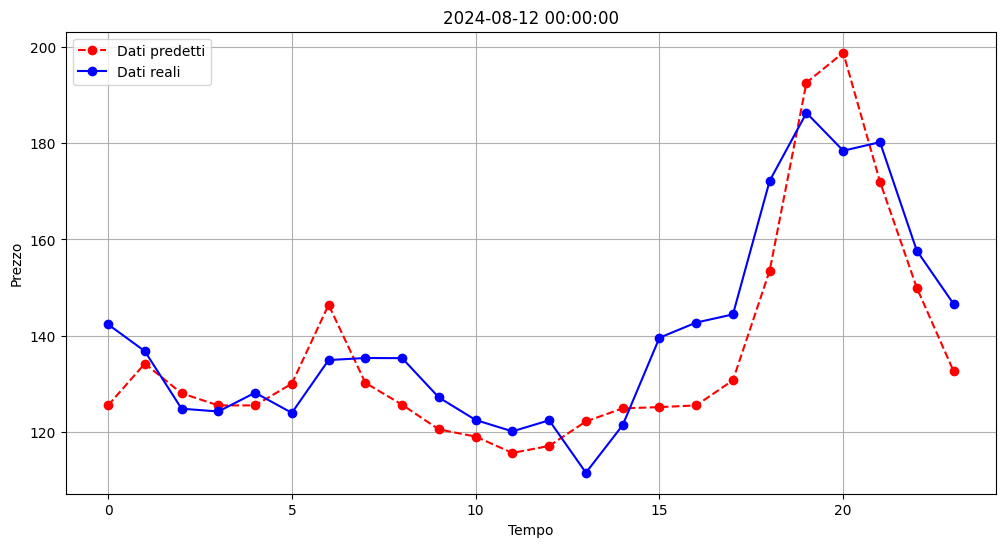

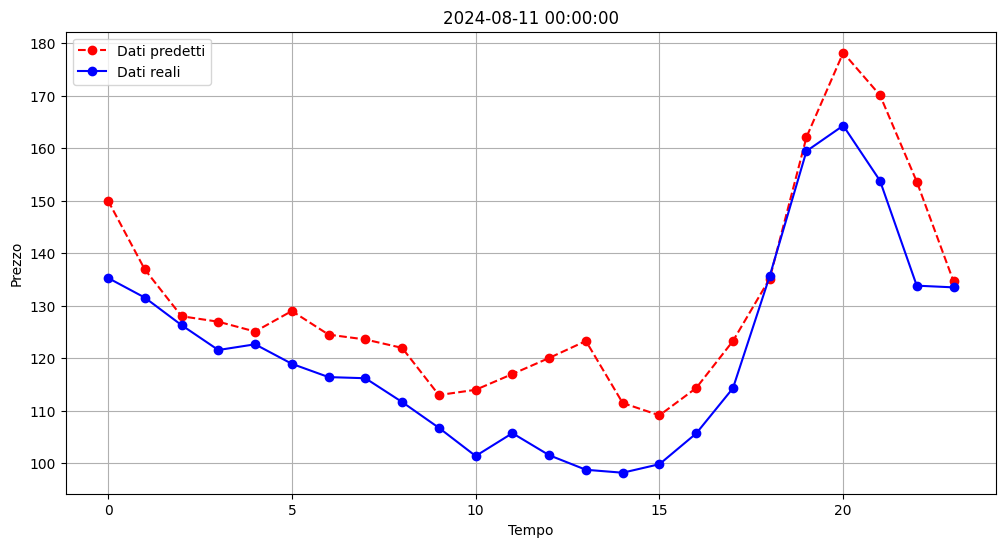

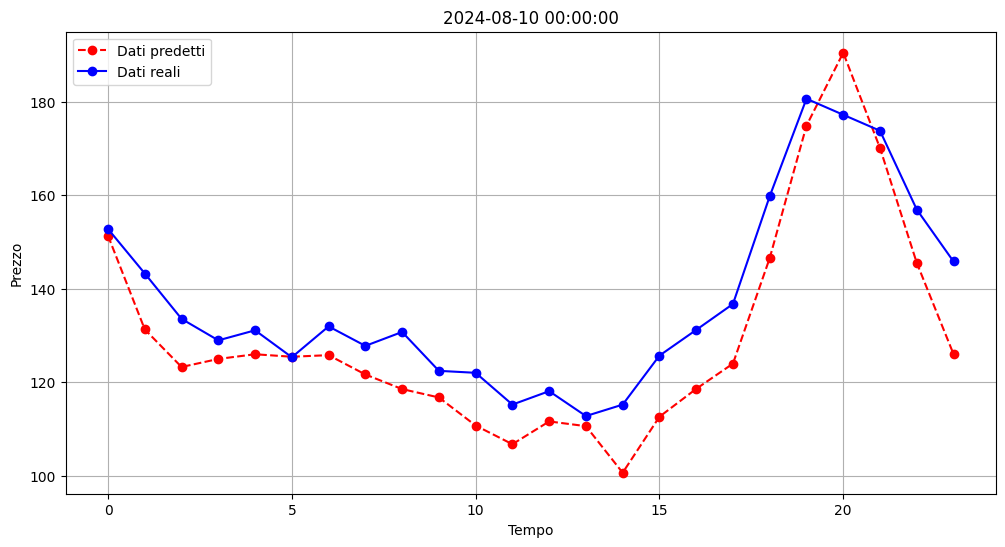

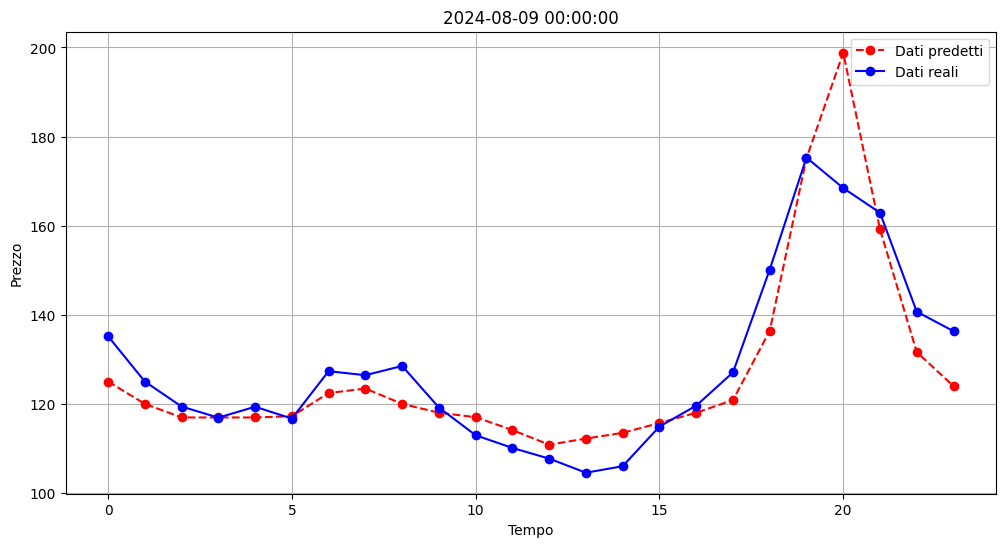

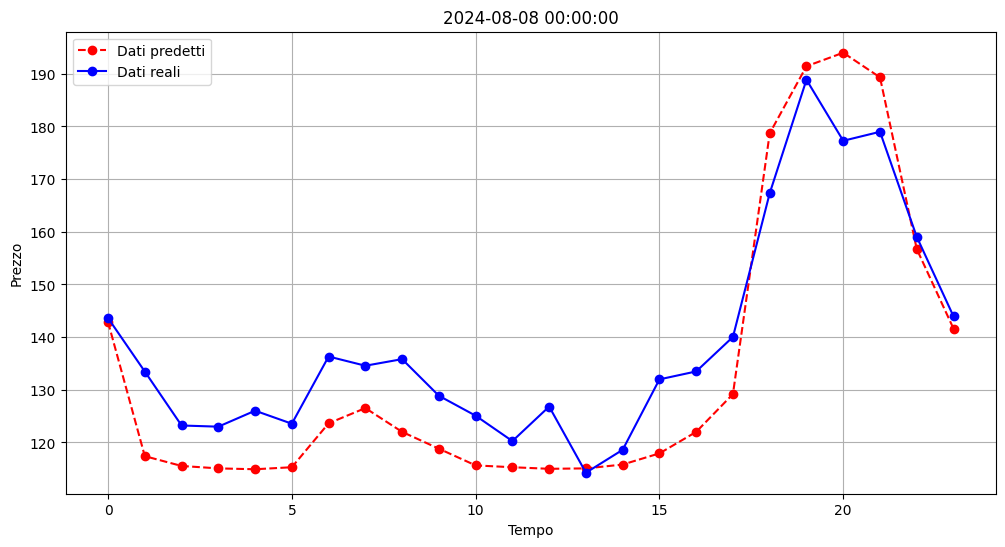

In [105]:
time_index = np.arange(24)

for i in range(20, 25):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, Y_test[-i, :], label='Dati predetti', color='red', linestyle='--', marker='o')
    plt.plot(time_index, Y_test_pred[-i, :], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.title(list(indexTest.index)[-i])
    plt.grid(True)
    plt.show()

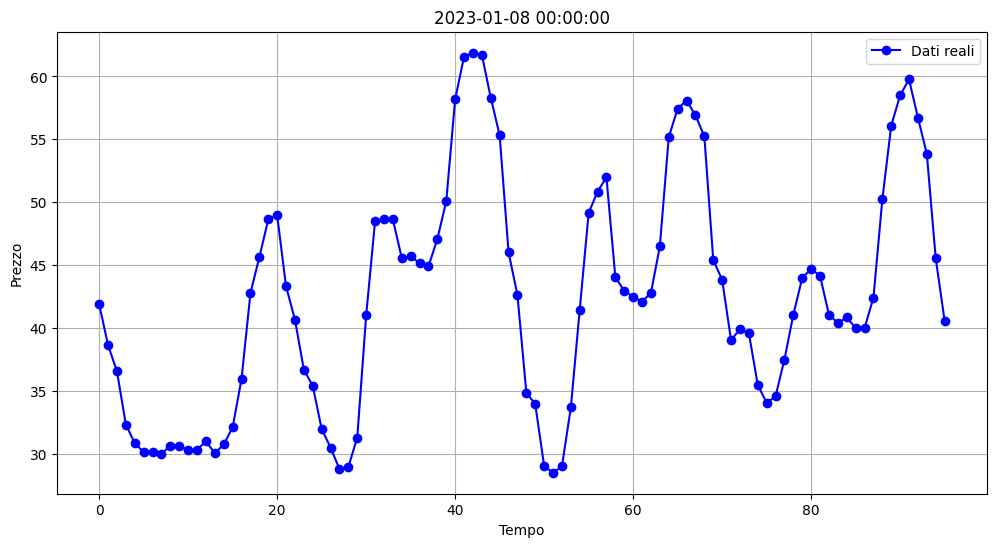

In [106]:
# PLOT DATI DI TRAIN
time_index = np.arange(24*4)

for i in range(0, 1):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, train_df['Price'].iloc[i:i+24*4], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.title(list(indexTest.index)[i])
    plt.grid(True)
    plt.show()

In [107]:
total_pred_days = X_test.shape[0]
total_train_days = X_train.shape[0]

total_train_days, total_pred_days

(1089, 602)

## Metrics computation

In [108]:
MAE_LEAR = MAE(np.hstack(Y_test), np.hstack(Y_test_pred))
sMAPE_LEAR = sMAPE(np.hstack(Y_test), np.hstack(Y_test_pred))
MAPE_LEAR = mean_absolute_percentage_error(np.hstack(Y_test), np.hstack(Y_test_pred))

In [109]:
MAE_LEAR, sMAPE_LEAR, MAPE_LEAR

(12.1292249505419, 0.1164136192789508, 0.17921640409098627)

## DNN -  Ottimizzazione iperparametri

In [170]:
path_dataset = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP"
test_start_date = pd.to_datetime('2023-01-01 00:00:00')
test_end_date = pd.to_datetime('2024-08-31 23:00:00')

In [187]:
# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = 'IT'

# Number of years (a year is 364 days) in the test dataset.
# years_test = len(test_df)/364
years_test = 1.67

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = test_start_date
end_test_date = test_end_date

# Boolean that selects whether the validation and training datasets are shuffled
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new hyperparameter optimization or we restart an existing one
new_hyperopt = 1

# Number of years used in the training dataset for recalibration
# calibration_window = len(train_df)/364
calibration_window = 3

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 1

# Number of iterations for hyperparameter optimization
max_evals = 50

path_datasets_folder = path_dataset
path_hyperparameters_folder = path +  "/experimental_files/"

In [188]:
# Check documentation of the hyperparameter_optimizer for each of the function parameters
# In this example, we optimize a model for the PJM market.
# We consider two directories, one for storing the datasets and the other one for the experimental files.
# We start a hyperparameter optimization from scratch. We employ 1500 iterations in hyperopt,
# 2 years of test data, a DNN with 2 hidden layers, a calibration window of 4 years,
# we avoid data augmentation,  and we provide an experiment_id equal to 1
hyperparameter_optimizer_customized(path_datasets_folder=path_datasets_folder, 
                         path_hyperparameters_folder=path_hyperparameters_folder, 
                         new_hyperopt=new_hyperopt, max_evals=max_evals, nlayers=nlayers, dataset=dataset, 
                         years_test=years_test, calibration_window=calibration_window, 
                         shuffle_train=shuffle_train, data_augmentation=0, experiment_id=experiment_id,
                         begin_test_date=begin_test_date, end_test_date=end_test_date)

Test datasets: 2023-01-01 00:00:00 - 2024-08-31 23:00:00




Tested 1/50 iterations.
Best MAE - Validation Dataset
  MAE: 150.1 | sMAPE: 172.16 %

Best MAE - Test Dataset
  MAE: 110.7 | sMAPE: 181.43 %




Tested 2/50 iterations.
Best MAE - Validation Dataset
  MAE: 114.6 | sMAPE: 78.03 %

Best MAE - Test Dataset
  MAE: 34.7 | sMAPE: 32.67 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 3/50 iterations.
Best MAE - Validation Dataset
  MAE: 114.6 | sMAPE: 78.03 %

Best MAE - Test Dataset
  MAE: 34.7 | sMAPE: 32.67 %




Tested 4/50 iterations.
Best MAE - Validation Dataset
  MAE: 111.2 | sMAPE: 76.50 %

Best MAE - Test Dataset
  MAE: 25.2 | sMAPE: 22.65 %




Tested 5/50 iterations.
Best MAE - Validation Dataset
  MAE: 109.1 | sMAPE: 73.13 %

Best MAE - Test Dataset
  MAE: 42.0 | sMAPE: 41.15 %




Tested 6/50 iterations.
Best MAE - Validation Dataset
  MAE: 22.6 | sMAPE: 16.76 %

Best MAE - Test Dataset
  MAE: 20.4 | sMAPE: 18.26 %




Tested 7/50 iterations.
Best MAE - Validation Dataset
  MAE: 22.6 | sMAPE: 16.76 %

Best MAE - Test Dataset
  MAE: 20.4 | sMAPE: 18.26 %




Tested 8/50 iterations.
Best MAE - Validation Dataset
  MAE: 22.6 | sMAPE: 16.76 %

Best MAE - Test Dataset
  MAE: 20.4 | sMAPE: 18.26 %




Tested 9/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.9 | sMAPE: 13.00 %

Best MAE - Test Dataset
  MAE: 14.0 | sMAPE: 13.31 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 10/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.9 | sMAPE: 13.00 %

Best MAE - Test Dataset
  MAE: 14.0 | sMAPE: 13.31 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 11/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.9 | sMAPE: 13.00 %

Best MAE - Test Dataset
  MAE: 14.0 | sMAPE: 13.31 %




Tested 12/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.9 | sMAPE: 13.00 %

Best MAE - Test Dataset
  MAE: 14.0 | sMAPE: 13.31 %




Tested 13/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.9 | sMAPE: 13.00 %

Best MAE - Test Dataset
  MAE: 14.0 | sMAPE: 13.31 %




Tested 14/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.9 | sMAPE: 13.00 %

Best MAE - Test Dataset
  MAE: 14.0 | sMAPE: 13.31 %




Tested 15/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.9 | sMAPE: 13.00 %

Best MAE - Test Dataset
  MAE: 14.0 | sMAPE: 13.31 %




Tested 16/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.9 | sMAPE: 13.00 %

Best MAE - Test Dataset
  MAE: 14.0 | sMAPE: 13.31 %




Tested 17/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:95: RuntimeWarning: overflow encountered in sinh
  transformed_data = np.sinh(data)
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:67: RuntimeWarning: overflow encountered in multiply
  transformed_data[:, i] = data[:, i] * self.mad[i] + self.median[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\evaluation\_smape.py:118: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs(p_real - p_pred) / ((np.abs(p_real) + np.abs(p_pred)) / 2))




Tested 18/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %




Tested 19/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %




Tested 20/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %




Tested 21/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 22/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %




Tested 23/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %




Tested 24/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 25/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 26/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %




Tested 27/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 28/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 29/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 30/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 31/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 32/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 33/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 34/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 35/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 36/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 37/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 38/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 39/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 40/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 41/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 42/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 43/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 44/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 45/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 46/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 47/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 48/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]




Tested 49/50 iterations.
Best MAE - Validation Dataset
  MAE: 18.6 | sMAPE: 13.44 %

Best MAE - Test Dataset
  MAE: 15.1 | sMAPE: 13.88 %


c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: divide by zero encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]
c:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_wrangling.py:49: RuntimeWarning: invalid value encountered in divide
  transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]


In [189]:
import pickle as pc

# Percorso dove è stato salvato il file di ottimizzazione
trials_file_path = os.path.join(path_hyperparameters_folder, 'DNN_hyperparameters_nl' + str(nlayers) +
                                '_dat' + str(dataset) + '_YT' + str(years_test) + 
                                '_SF' * shuffle_train + '_DA' * data_augmentation + 
                                '_CW' + str(calibration_window) + '_' + str(experiment_id))

# Caricare il file di trials salvato
with open(trials_file_path, "rb") as f:
    trials = pc.load(f)

In [190]:
# Miglior risultato dato dall'ottimizzatore
best_trial = trials.best_trial
best_trial

{'state': 2,
 'tid': 16,
 'spec': None,
 'result': {'loss': 18.568345532381777,
  'MAE Val': 18.568345532381777,
  'MAE Test': 15.05938058812696,
  'sMAPE Val': 13.440817162946688,
  'sMAPE Test': 13.880001633396702,
  'status': 'ok'},
 'misc': {'tid': 16,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'In: Covid': [16],
   'In: Exog-1 D': [16],
   'In: Exog-1 D-1': [16],
   'In: Exog-1 D-7': [16],
   'In: Exog-2 D': [16],
   'In: Exog-2 D-1': [16],
   'In: Exog-2 D-7': [16],
   'In: Holiday': [16],
   'In: Price D-1': [16],
   'In: Price D-2': [16],
   'In: Price D-3': [16],
   'In: Price D-7': [16],
   'In: WorkingDay': [16],
   'activation': [16],
   'batch_normalization': [16],
   'dropout': [16],
   'init': [16],
   'lambdal1': [],
   'lr': [16],
   'neurons1': [16],
   'neurons2': [16],
   'reg': [16],
   'scaleX': [16],
   'scaleY': [16],
   'seed': [16]},
  'vals': {'In: Covid': [0],
   'In: Exog-1 D': [0],
   'In: Exog-1 D-1': [1],
   'In: Exo

In [191]:
# Questa funzione del toolbox mette in automatico i parametri di ottimizzazione nel formato richiesto (dizionario) per il modello
opt_hyperparams = format_best_trial(best_trial)

In [209]:
# Metodo per passare da dataframe a dataset
X_train, Y_train, X_val, Y_val, X_test, Y_test, indexTest = \
    _build_and_split_XYs_customized(dfTrain=train_df,dfTest=test_df,  features=opt_hyperparams, n_exogenous_inputs=2, shuffle_train=True, percentage_val=0.25,
                        date_test=None, hyperoptimization=True, data_augmentation=False)

In [193]:
model = DNN(experiment_id=experiment_id, path_hyperparameter_folder=path_hyperparameters_folder, nlayers=nlayers,
            dataset='IT', years_test=years_test, shuffle_train=shuffle_train, data_augmentation=data_augmentation, calibration_window=calibration_window) 

In [194]:
X_train_reg, X_val_reg, X_test_reg, Y_train_reg, Y_val_reg = model._regularize_data(X_train, X_val, X_test, Y_train, Y_val)

In [195]:
model.recalibrate(X_train_reg, Y_train_reg, X_val_reg, Y_val_reg)

In [196]:
Y_test_pred = model.predict(X_test_reg)

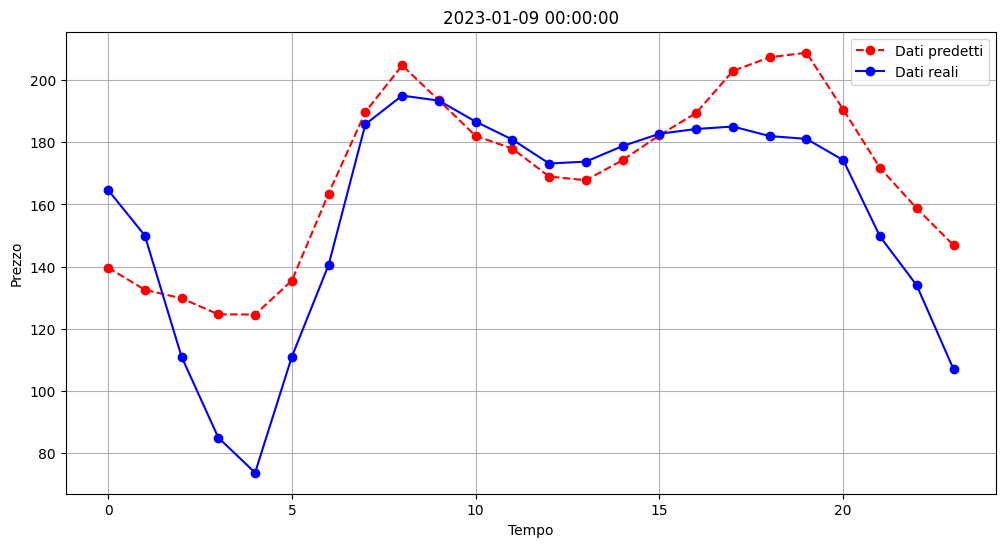

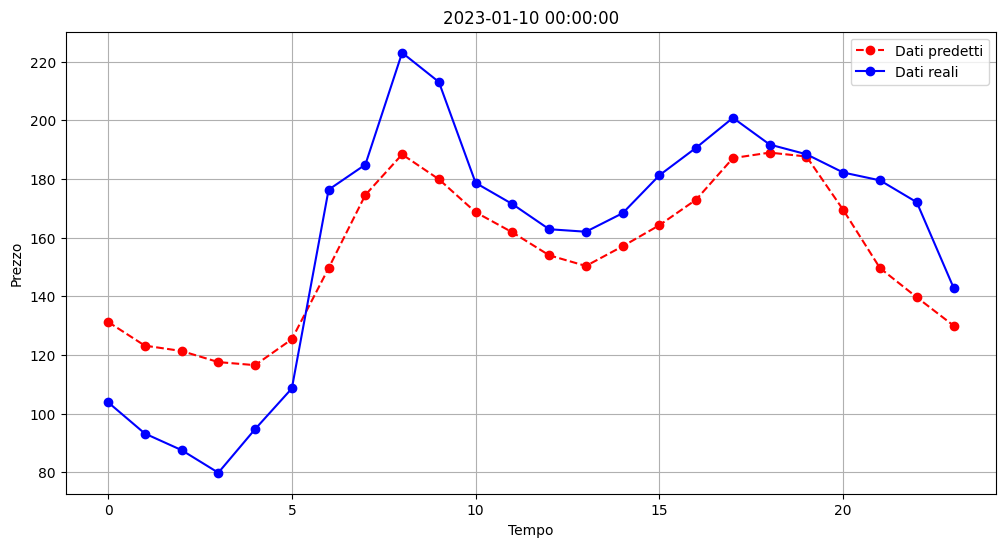

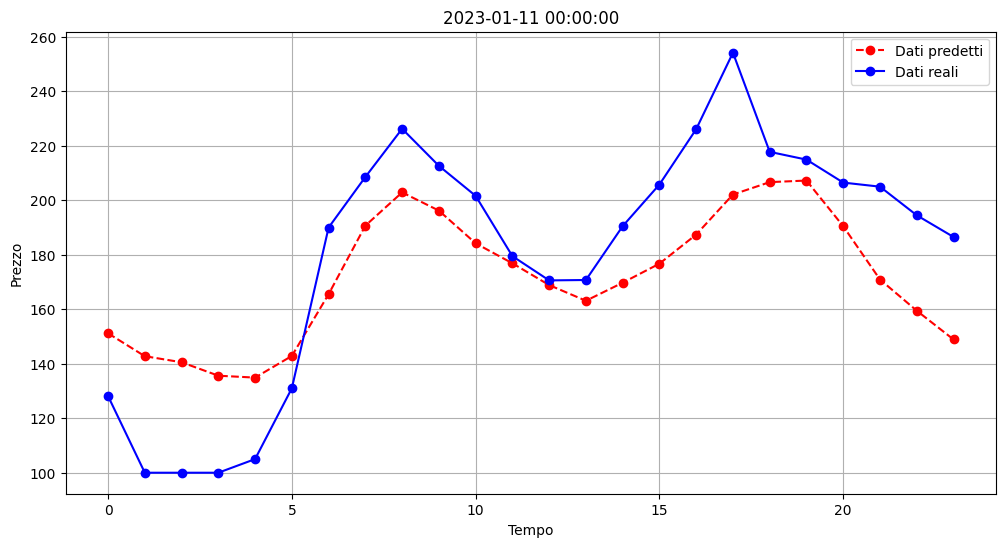

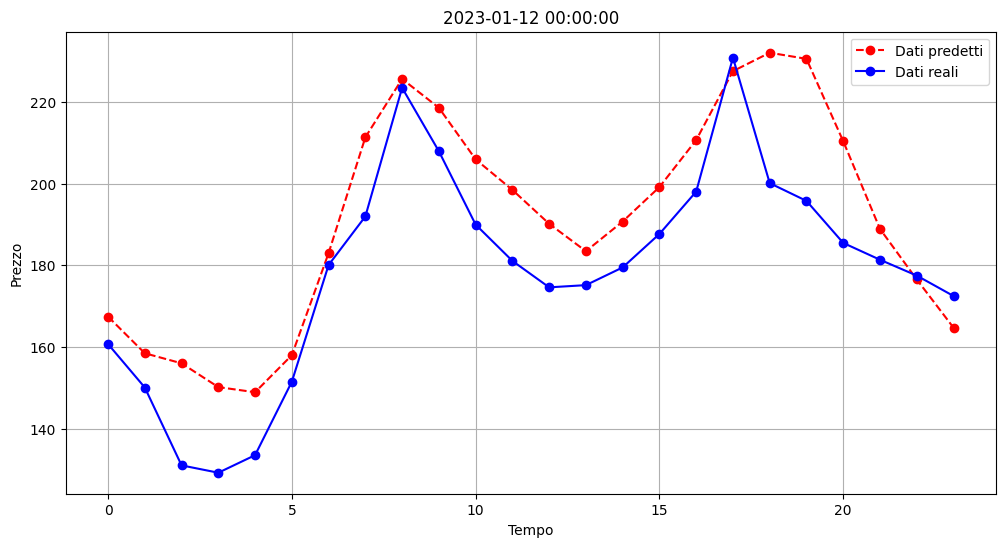

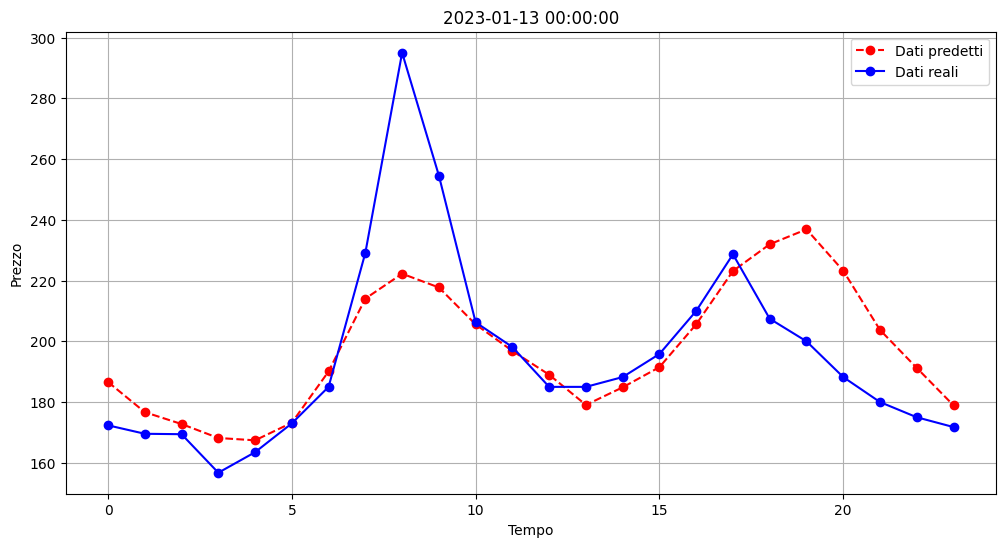

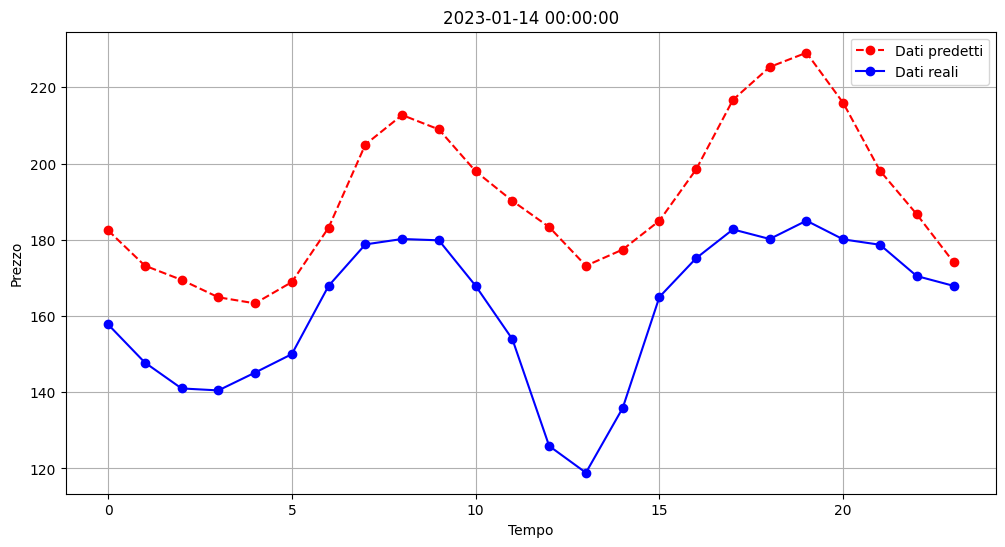

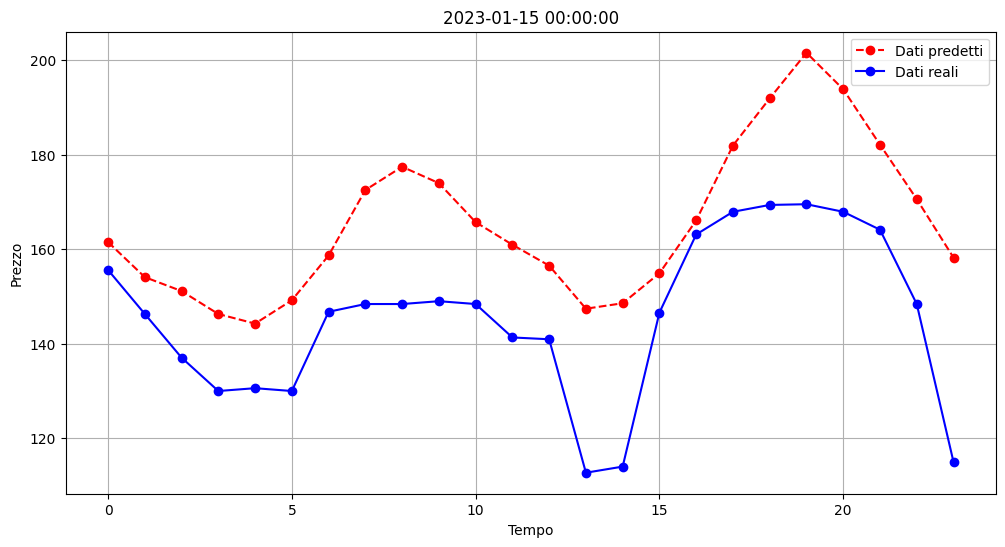

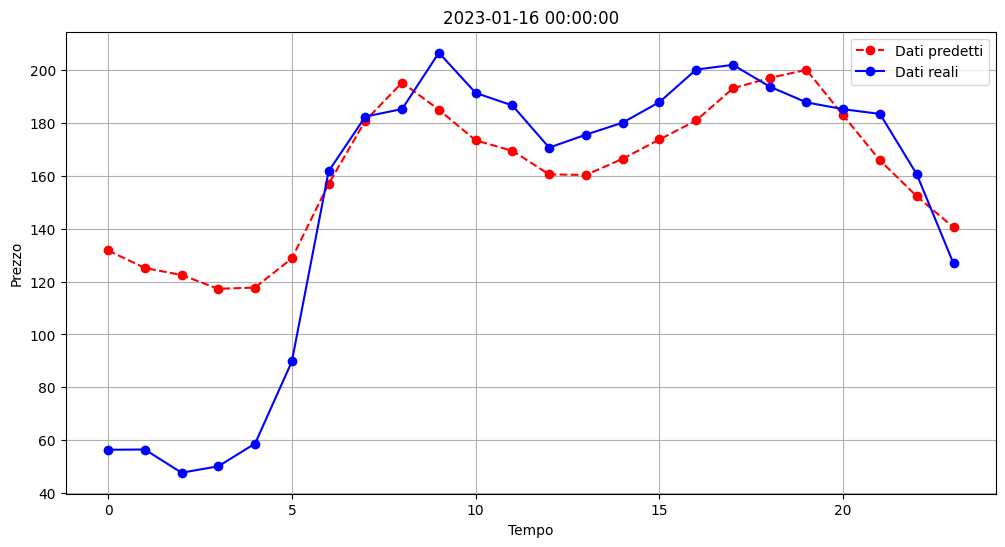

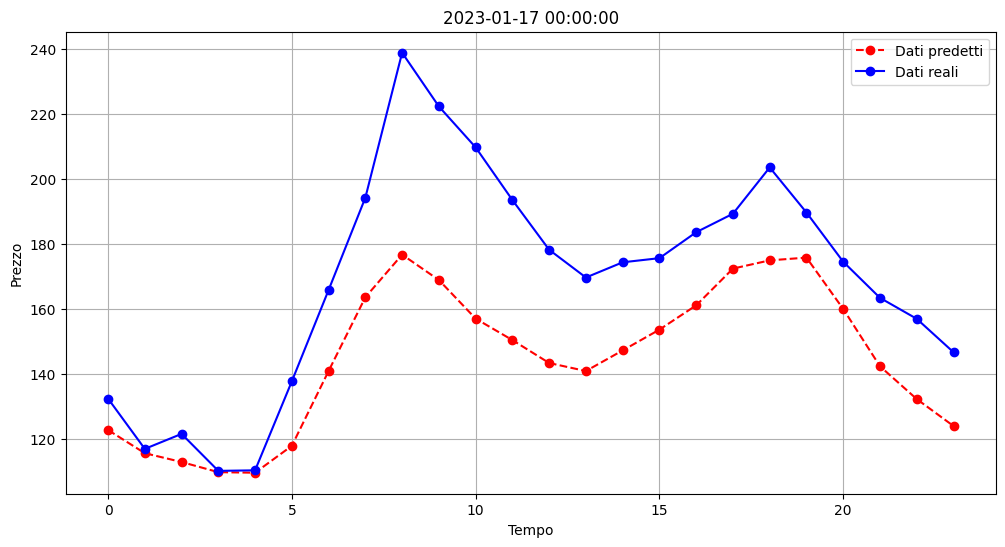

In [197]:
time_index = np.arange(24)


for i in range(1, 10):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, Y_test_pred[i, :], label='Dati predetti', color='red', linestyle='--', marker='o')
    plt.plot(time_index, Y_test[i, :], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.title(str(indexTest[i]))
    plt.grid(True)
    plt.show()

### Metrics computation

In [198]:
MAE_DNN = MAE(np.hstack(Y_test), np.hstack(Y_test_pred))
sMAPE_DNN = sMAPE(np.hstack(Y_test), np.hstack(Y_test_pred))
MAPE_DNN = mean_absolute_percentage_error(np.hstack(Y_test), np.hstack(Y_test_pred))

In [199]:
MAE_DNN, sMAPE_DNN, MAPE_DNN

(15.430006414811059, 0.14371180491472746, 0.26368054159378085)

## DNN Model

In [222]:
# Features (se non vuoi prenderle dal dizionario degli iperparametri ottimali/usarle tutte)
features = {'In: WorkingDay': 1,
 'In: Holiday' : 1,
 'In: Covid': 1,
 'In: Exog-1 D': 1,
 'In: Exog-1 D-1': 1,
 'In: Exog-1 D-7': 1,
 'In: Exog-2 D': 1,
 'In: Exog-2 D-1': 1,
 'In: Exog-2 D-7': 1,
 'In: Price D-1': 1,
 'In: Price D-2': 1,
 'In: Price D-3': 1,
 'In: Price D-7': 1,
}

In [201]:
## Features se vuoi considerare quelle restituite dall'optimizer
# features = opt_hyperparams

In [223]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, indexTest = \
    _build_and_split_XYs_customized(dfTrain=train_df,dfTest=test_df,  features=features, n_exogenous_inputs=2, shuffle_train=True, percentage_val=0.25,
                        date_test=None, hyperoptimization=True, data_augmentation=False)

In [224]:
# Normalizzazione delle feature numeriche
X_train_norm, Y_train_norm, X_val_norm, Y_val_norm, X_test_norm , scaler_y = rescale(X_train, Y_train, X_val, Y_val, X_test)

In [225]:
neurons = [150, 150]
n_features = X_train.shape[1]
dropout = 0.5

# Scaler = None perchè normalizziamo noi prima
# Lamba_reg è il termine di regolarizzazione -> l1 o l2 ma i risultati migliori si ottengono senza
model_dnn = DNNModel(neurons=neurons, n_features= n_features, dropout=dropout, batch_normalization=False, scaler=None, lambda_reg=None, lr=0.003)
model_dnn.fit(X_train_norm, Y_train_norm, X_val_norm, Y_val_norm)



In [226]:
Y_test_pred_norm = model_dnn.predict(X_test_norm)
# Riportiamo i dati predetti alla scala reale
Y_test_pred = scaler_y.inverse_transform(Y_test_pred_norm)
Y_test_pred

array([[161.24606 , 149.66208 , 152.33481 , ..., 185.3938  , 170.07661 ,
        162.00208 ],
       [177.68811 , 170.32314 , 166.12093 , ..., 208.54317 , 197.51363 ,
        183.34355 ],
       [152.75392 , 147.68988 , 142.08212 , ..., 176.26022 , 165.73262 ,
        155.40929 ],
       ...,
       [127.09958 , 119.861145, 115.95557 , ..., 142.0516  , 132.67233 ,
        125.00514 ],
       [131.32404 , 124.40579 , 119.85689 , ..., 146.8743  , 137.5379  ,
        129.22234 ],
       [115.01197 , 108.78249 , 106.601234, ..., 127.246635, 121.33972 ,
        114.39145 ]], dtype=float32)

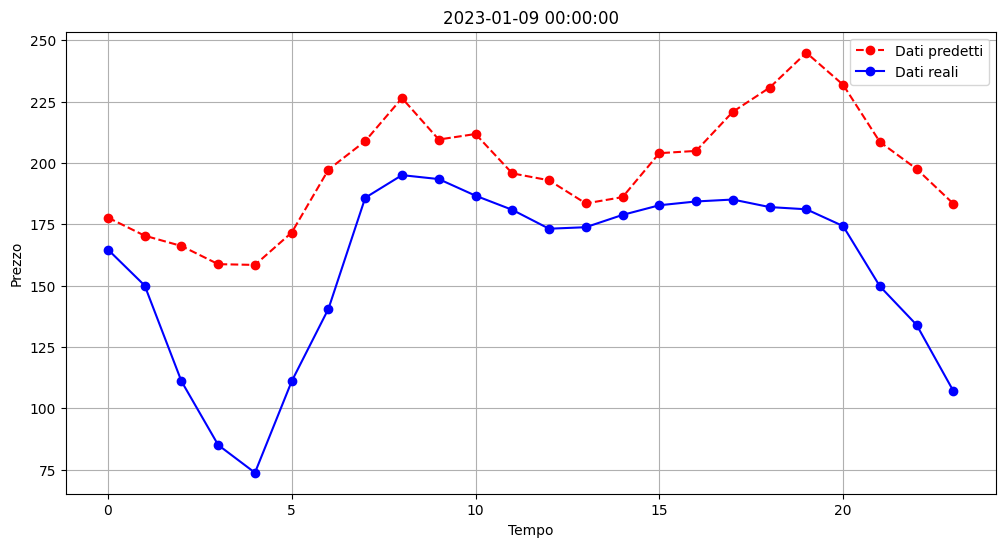

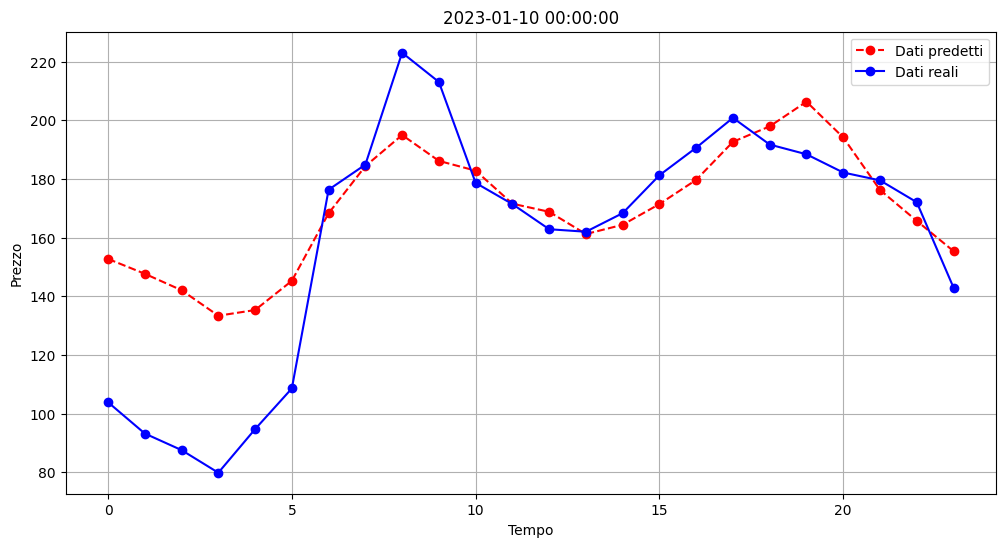

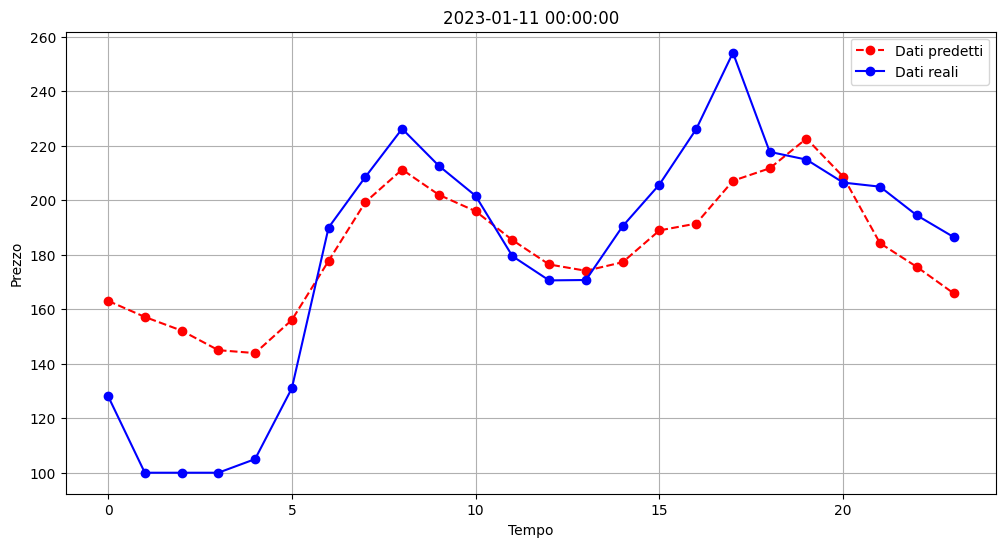

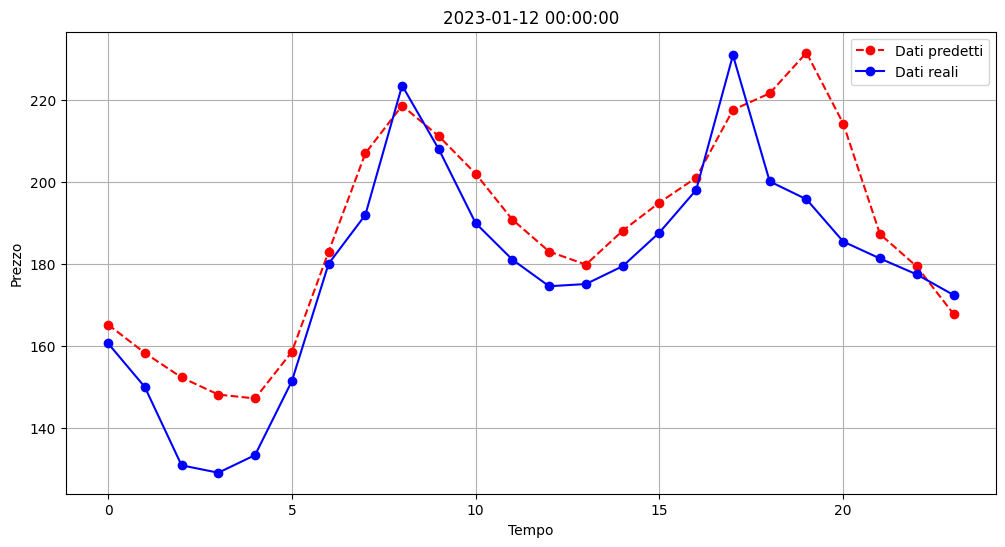

In [227]:
time_index = np.arange(24)
for i in range(1, 5):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, Y_test_pred[i, :], label='Dati predetti', color='red', linestyle='--', marker='o')
    plt.plot(time_index, Y_test[i, :], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.title(str(indexTest[i]))
    plt.grid(True)
    plt.show()

In [228]:
MAE_DNN = MAE(np.hstack(Y_test), np.hstack(np.array(Y_test_pred))) 
sMAPE_DNN = sMAPE(np.hstack(Y_test), np.hstack(np.array(Y_test_pred))) 
MAPE_DNN = mean_absolute_percentage_error(np.hstack(Y_test), np.hstack(np.array(Y_test_pred)))
MAE_DNN, sMAPE_DNN, MAPE_DNN

(14.717410765254803, 0.13961715267630248, 0.25876834814475325)